In [1]:
import os
import pandas as pd
from importlib import reload
import numpy as np
from tqdm import *
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from model import params

In [2]:
!ls -l nohup.out

-rw------- 1 user79 user79 62549026 5月  20 04:13 nohup.out


In [3]:
# 总目录
root_path = rf'/home/user79/model_train_0426'
# 模型存储路径
model_path = rf'{root_path}/model_test'
# 打分存储路径
model_res_path = rf'{root_path}/model_res'
for path in [root_path, model_path, model_res_path]:
    os.makedirs(path, exist_ok=True)

In [4]:
# 拼接各个fold的结果，使用zscore集成
def concat_model(basic_name):
    market = 'ALL'
    model_res = []
    for valid_period in ['validperiod1', 'validperiod2', 'validperiod3', 'validperiod4']: 
        data_path = rf"{model_path}/{basic_name}/{market}-{valid_period}"
        date_list = list(set([x[:8] for x in os.listdir(data_path) if x > "2022"]))
        date_list.sort()
        all_res = []
        for date in date_list:
            date_res = pd.read_pickle(f'{data_path}/{date}.pkl').T
            date_res.index = [date] * len(date_res)
            all_res.append(date_res)
        all_res = pd.concat(all_res, axis=0).sort_index()
        all_res.index.name = "date"
        model_res.append(all_res.apply(lambda x: (x - x.mean()) / x.std(), axis=1))
    model_res = sum(model_res)
    model_res.reset_index().to_feather(rf"{model_res_path}/{market}_zscore_{basic_name}.fea")
    return model_res

In [5]:
# 获取打分的ic均值和每期按流动性加权的label均值
def analysis_model(score, ret_data, liquid_data, money):
    start = '20230101'
    end = '20240630'
    model_score = score.copy()
    label_ret = []
    ic = []
    for date in model_score.loc[start:end].index:
        code_rank = model_score.loc[date].sort_values(ascending=False)
        ret = ret_data.loc[date].reindex(code_rank.index).fillna(0) * 100
        liquid = liquid_data.loc[date].reindex(code_rank.index).fillna(0)
        total_hold = 0
        total_earned = 0
        for num,code in enumerate(code_rank.index):
            if num >= 500:
                break
            if (money - total_hold) < 1:
                break
            hold_money = min(money - total_hold, liquid[code])
            total_hold += hold_money
            total_earned += ret[code] * hold_money
        total_ret = total_earned / money
        label_ret.append(total_ret)
        ic.append(code_rank.corr(ret))
    
    ic = pd.Series(ic, dtype='float').mean()
    label_ret = pd.Series(label_ret).mean()
    return dict(ic=ic, label_ret=label_ret)

In [6]:
# 获取某个模型的集成打分
model_name = 'nn--fac20250212--label1--dropout0.4'
score = concat_model(model_name)

In [7]:
# 查看打分的ic均值和每期按流动性加权的label均值
# ic和label均值越高越好
result = analysis_model(score, params.ret_data, params.liquid_data, 1.5e9)
result

{'ic': 0.11482592093626948, 'label_ret': 0.23849500692259054}

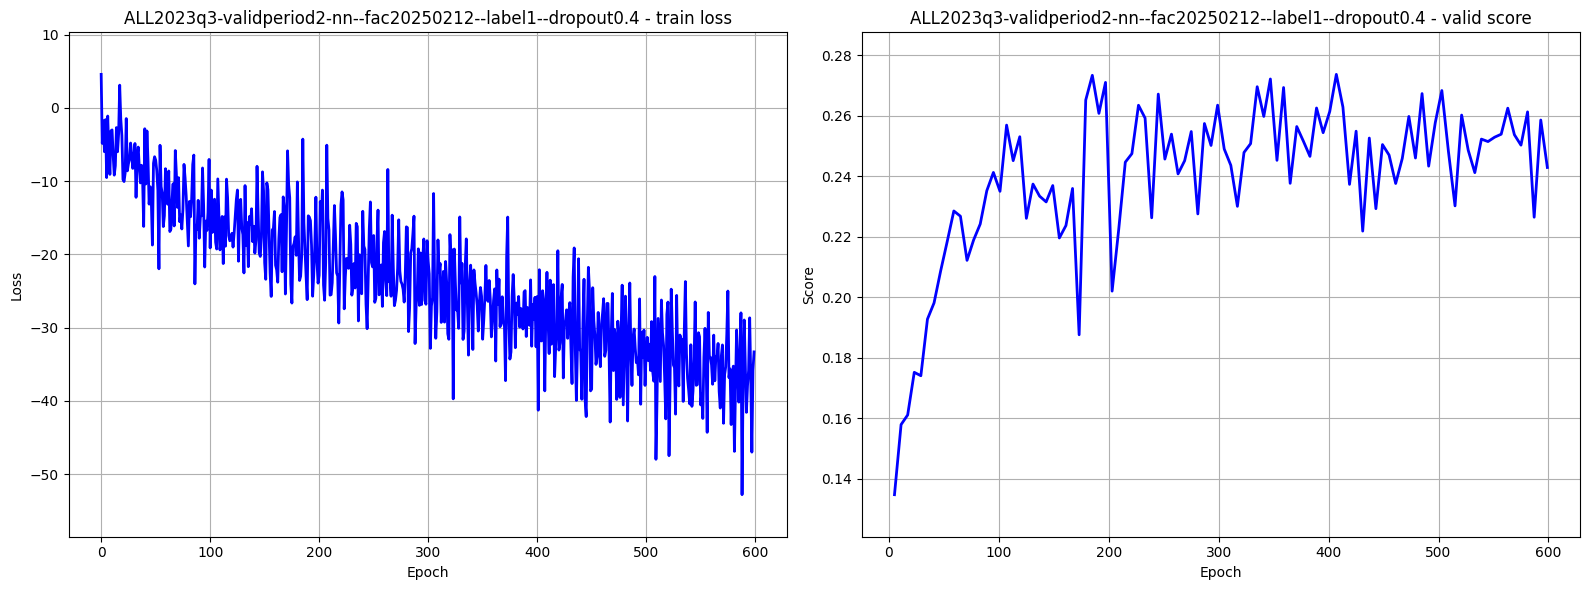

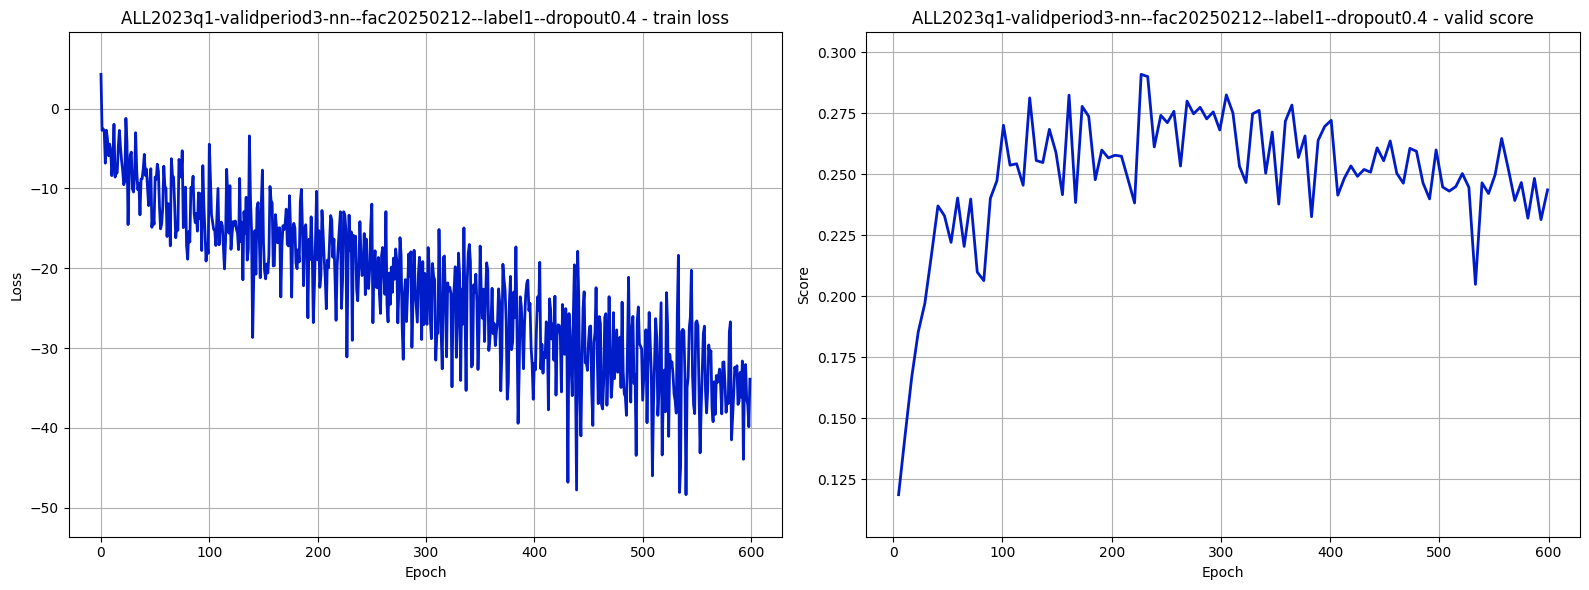

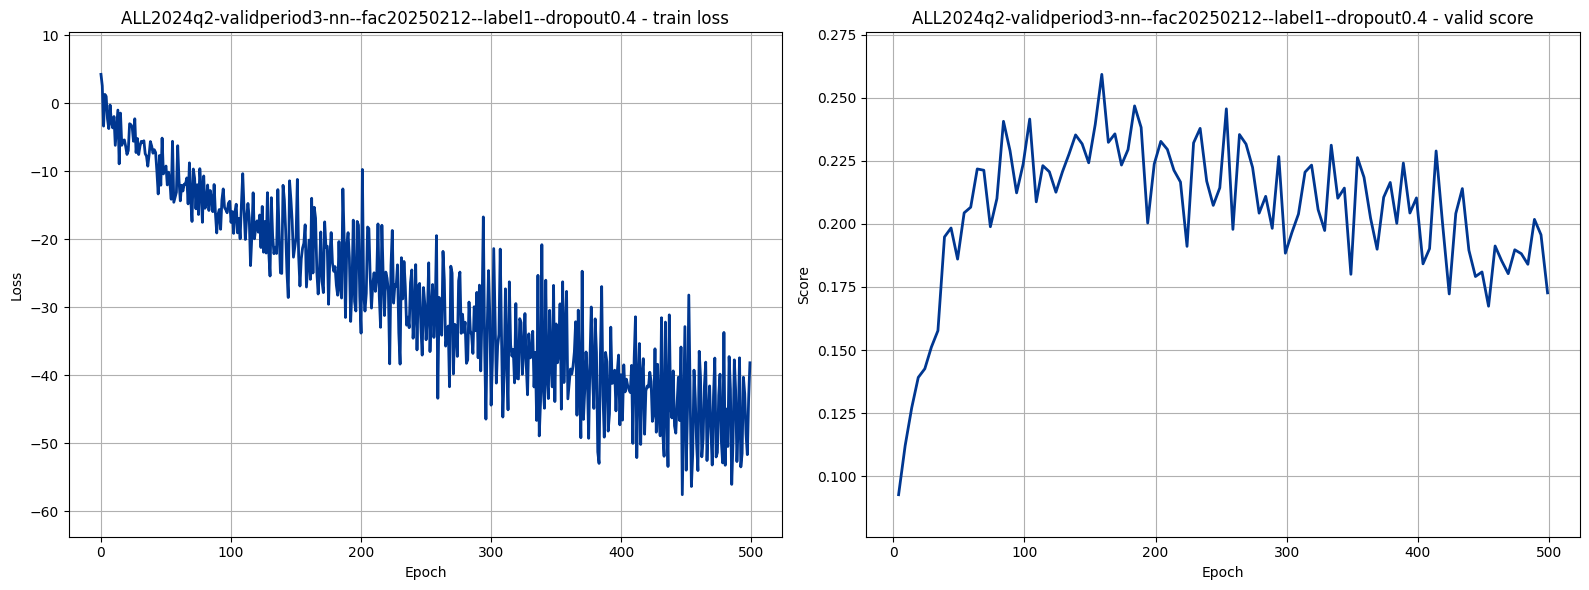

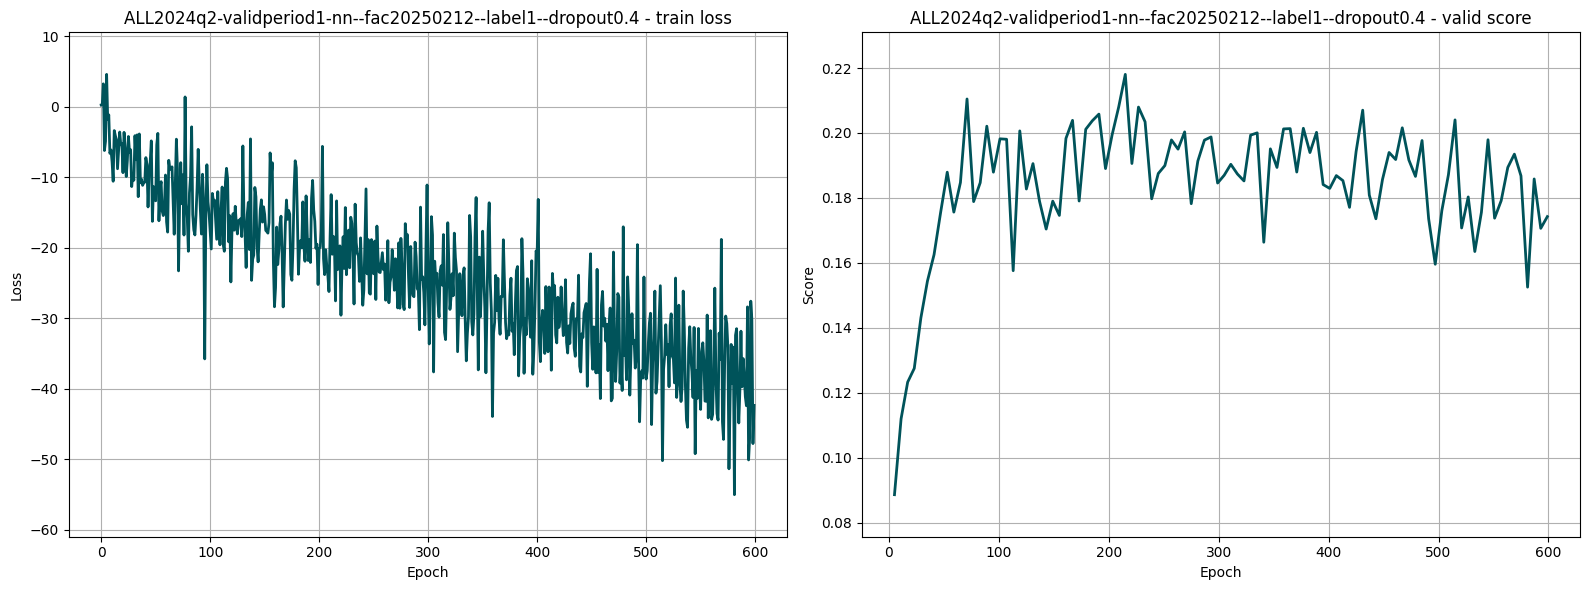

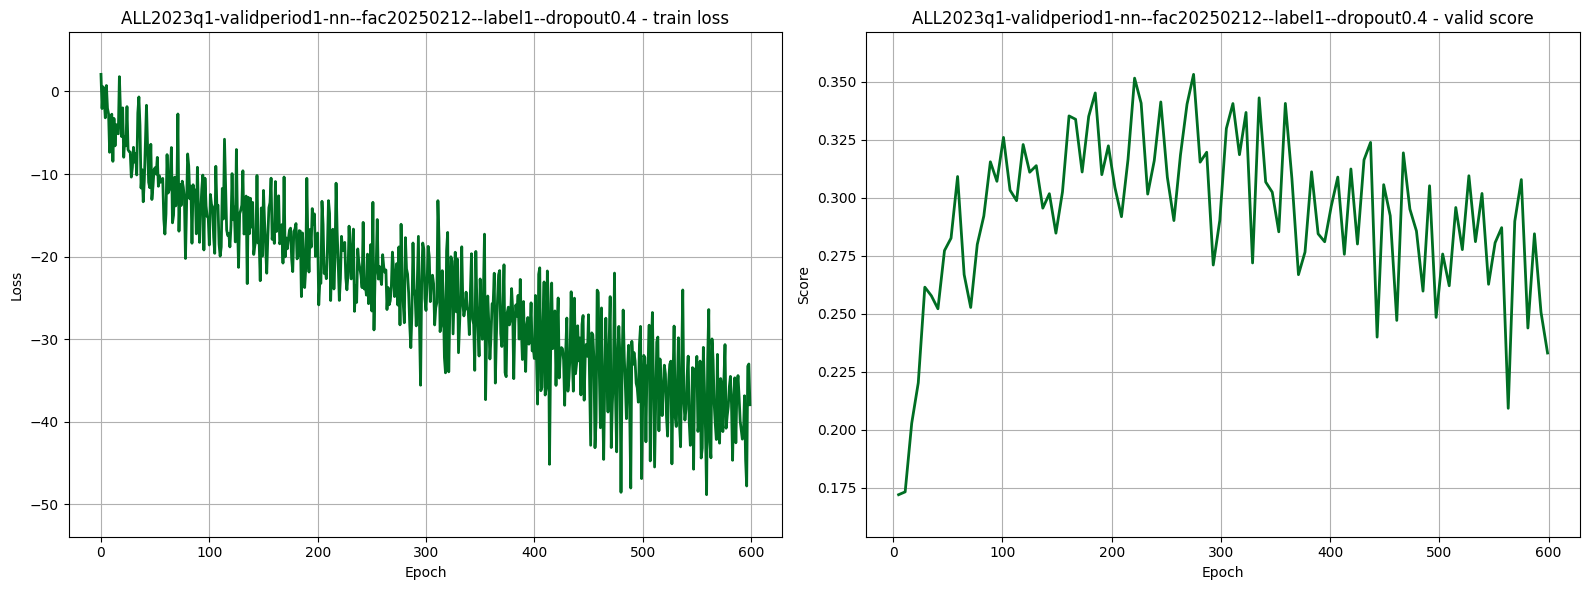

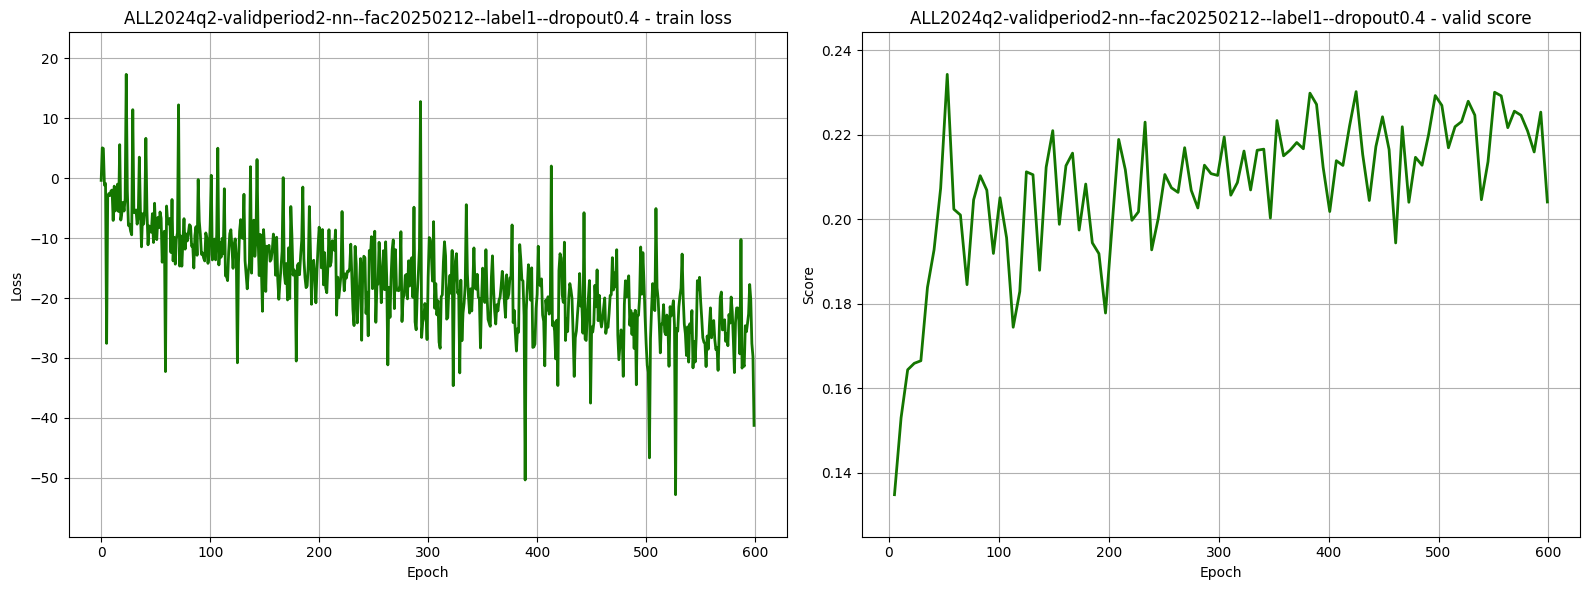

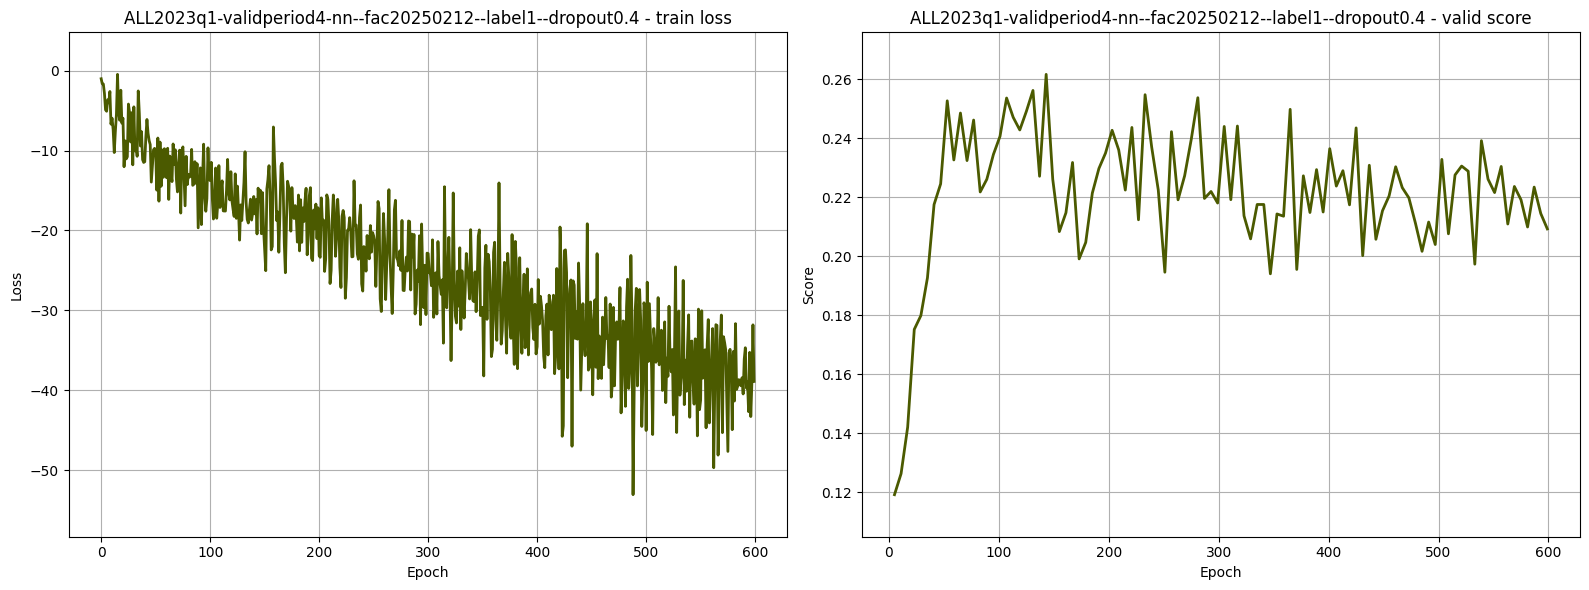

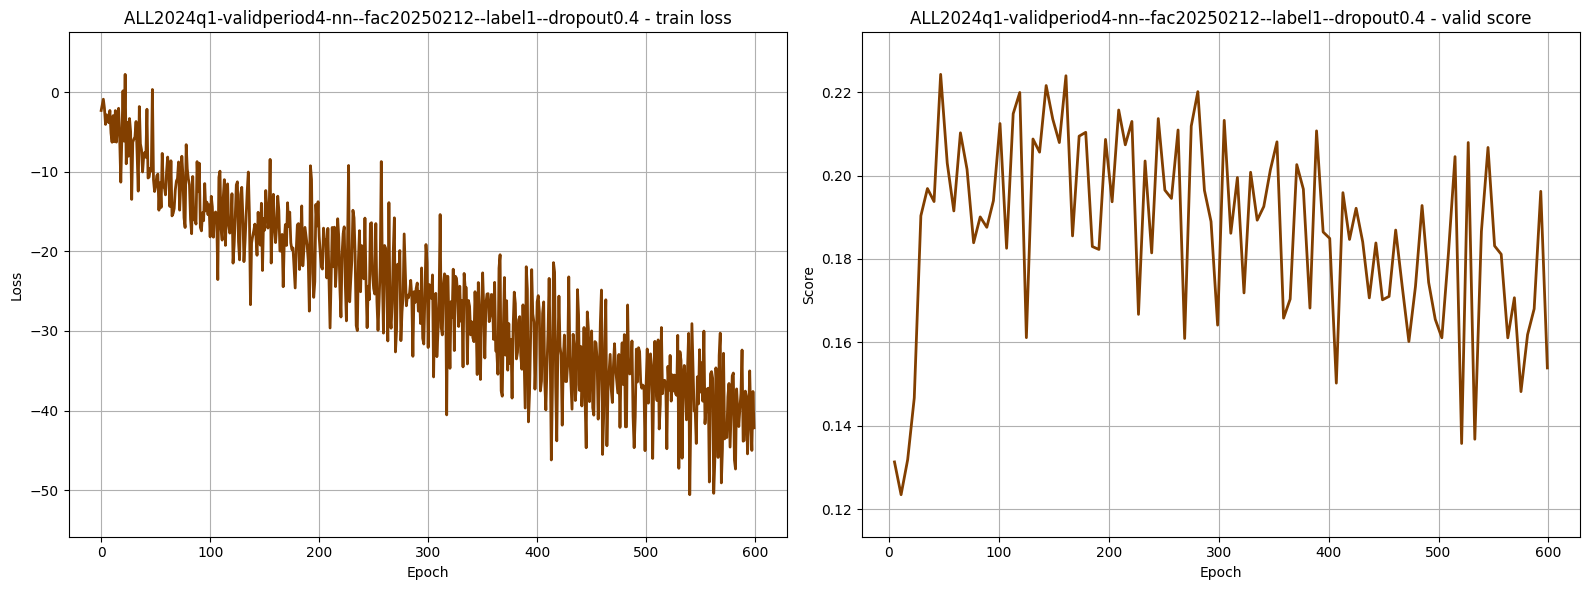

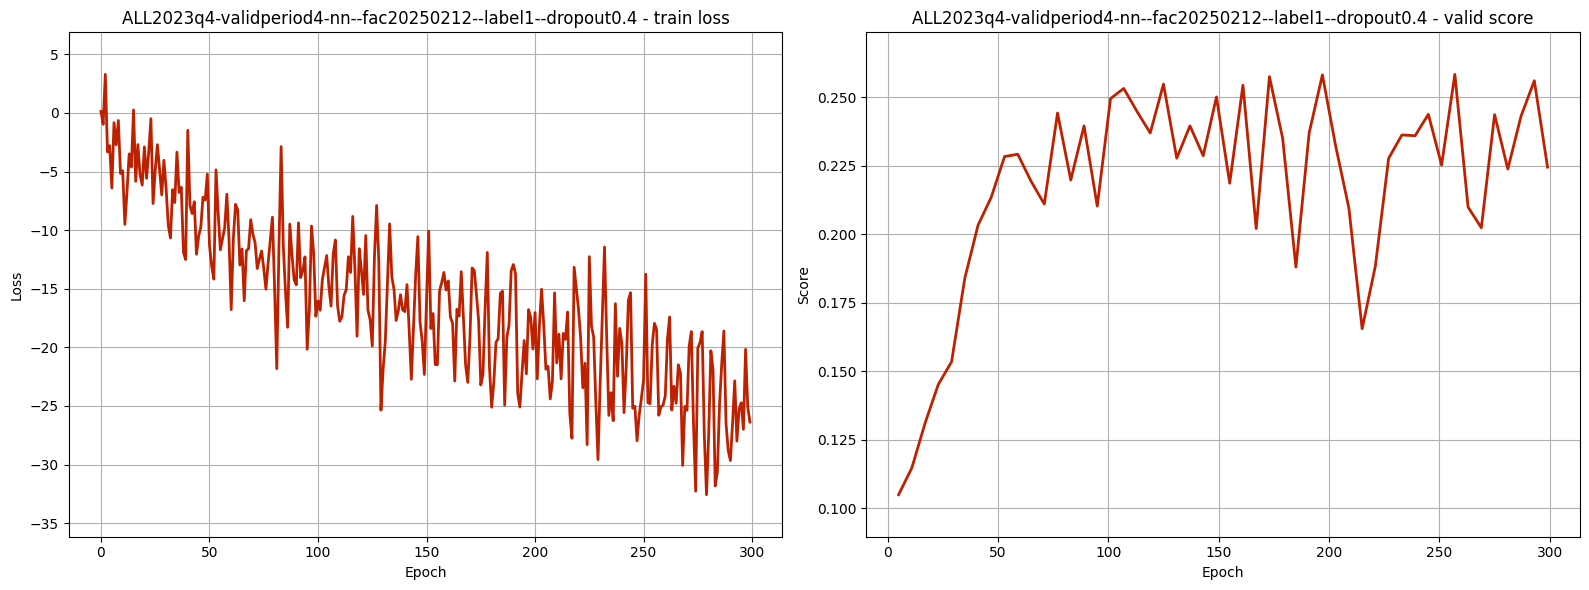

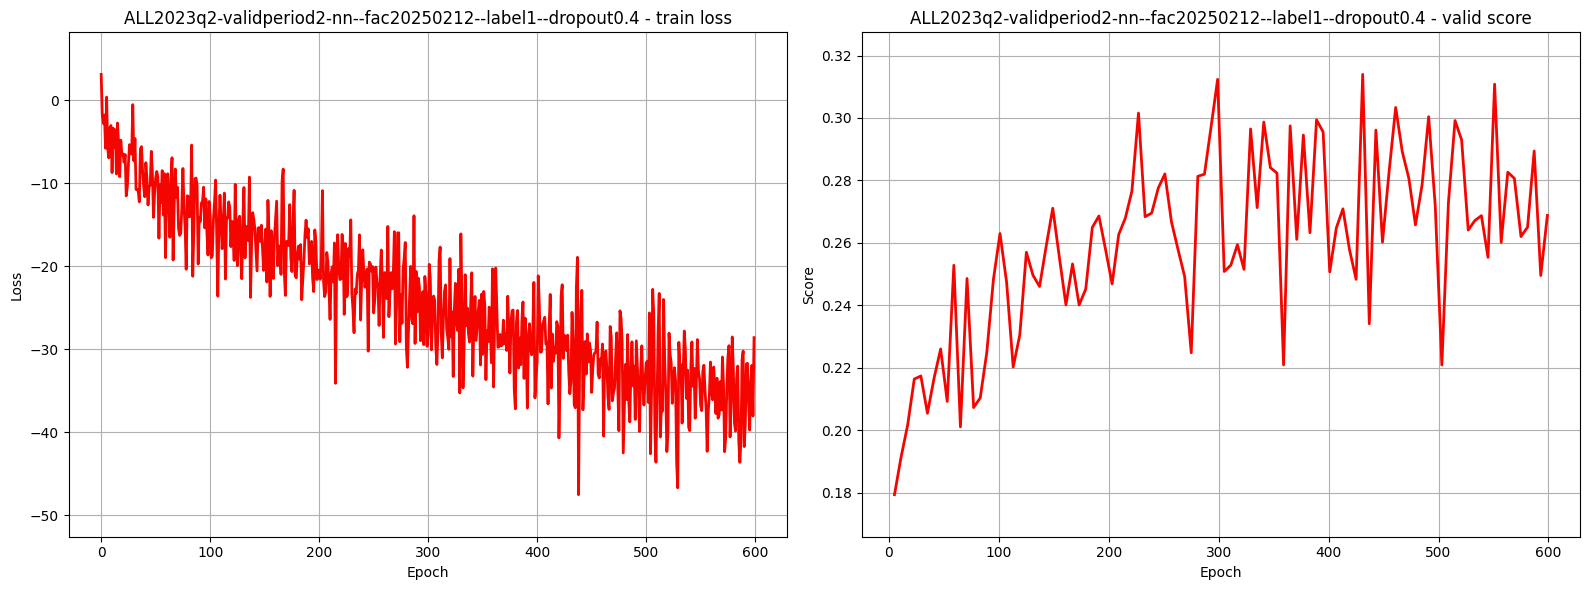

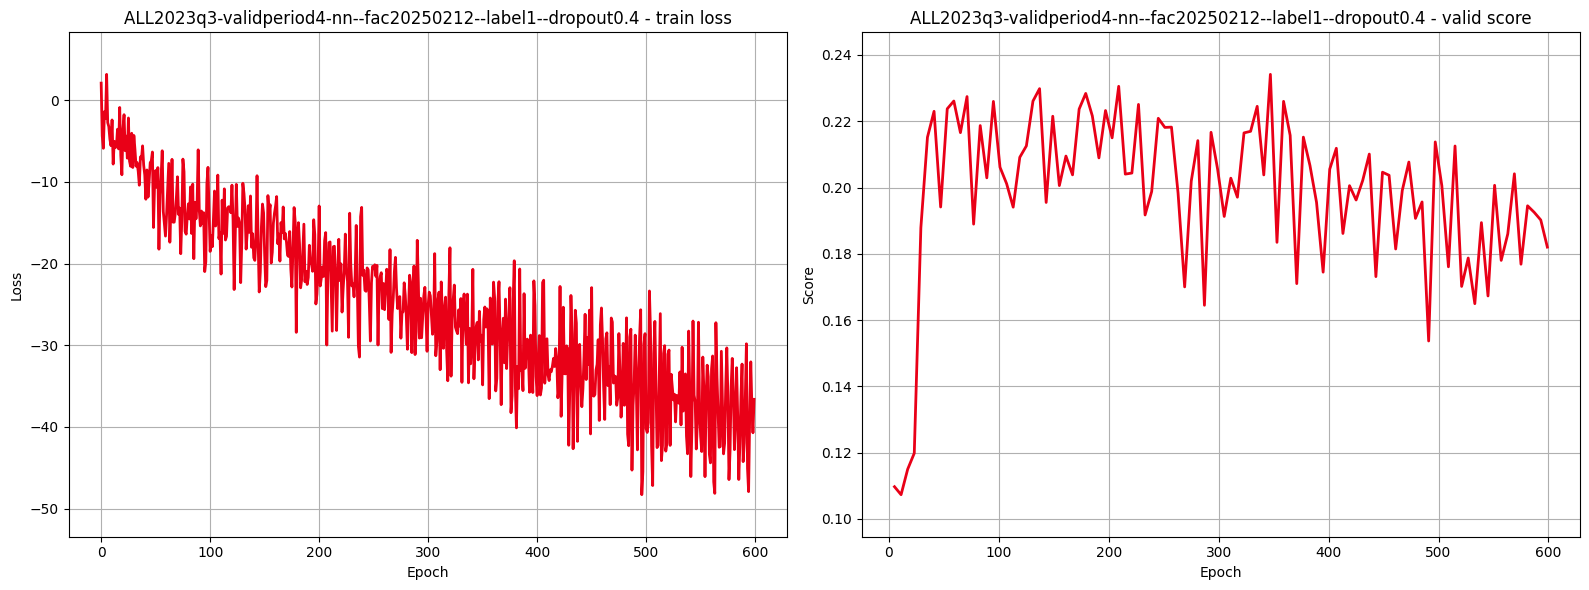

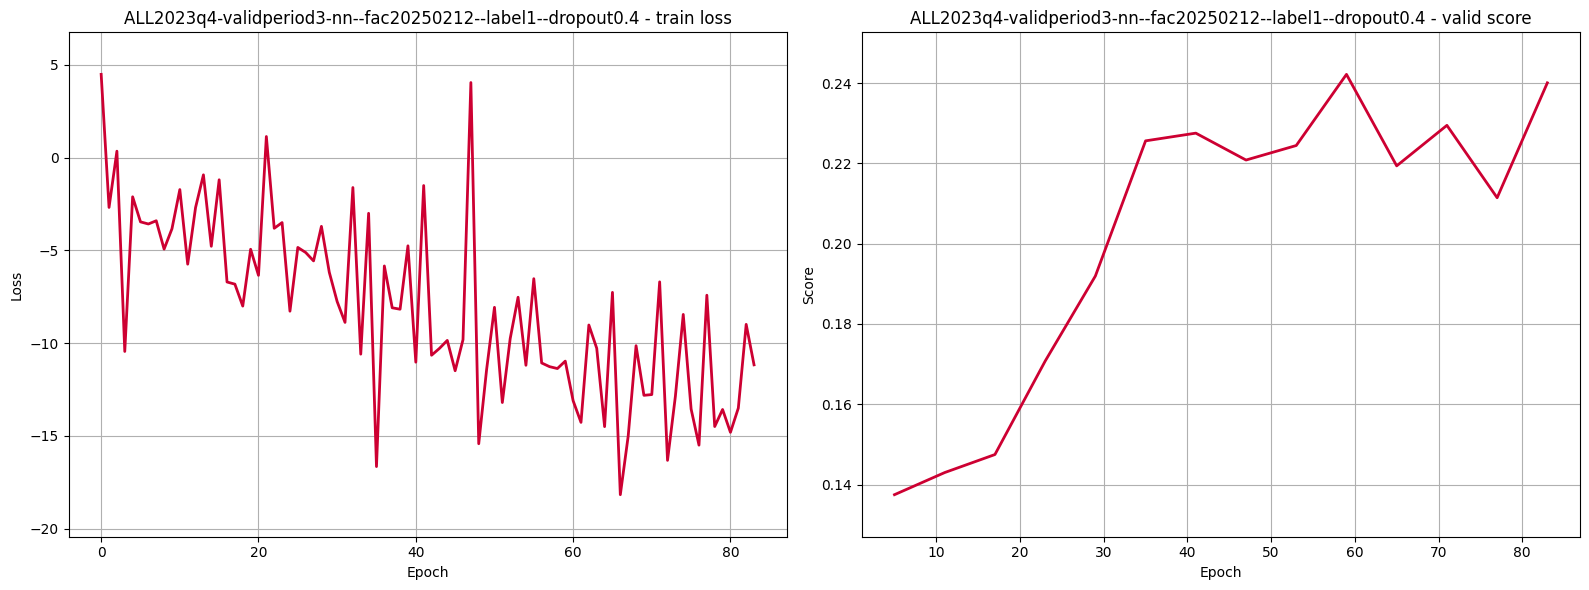

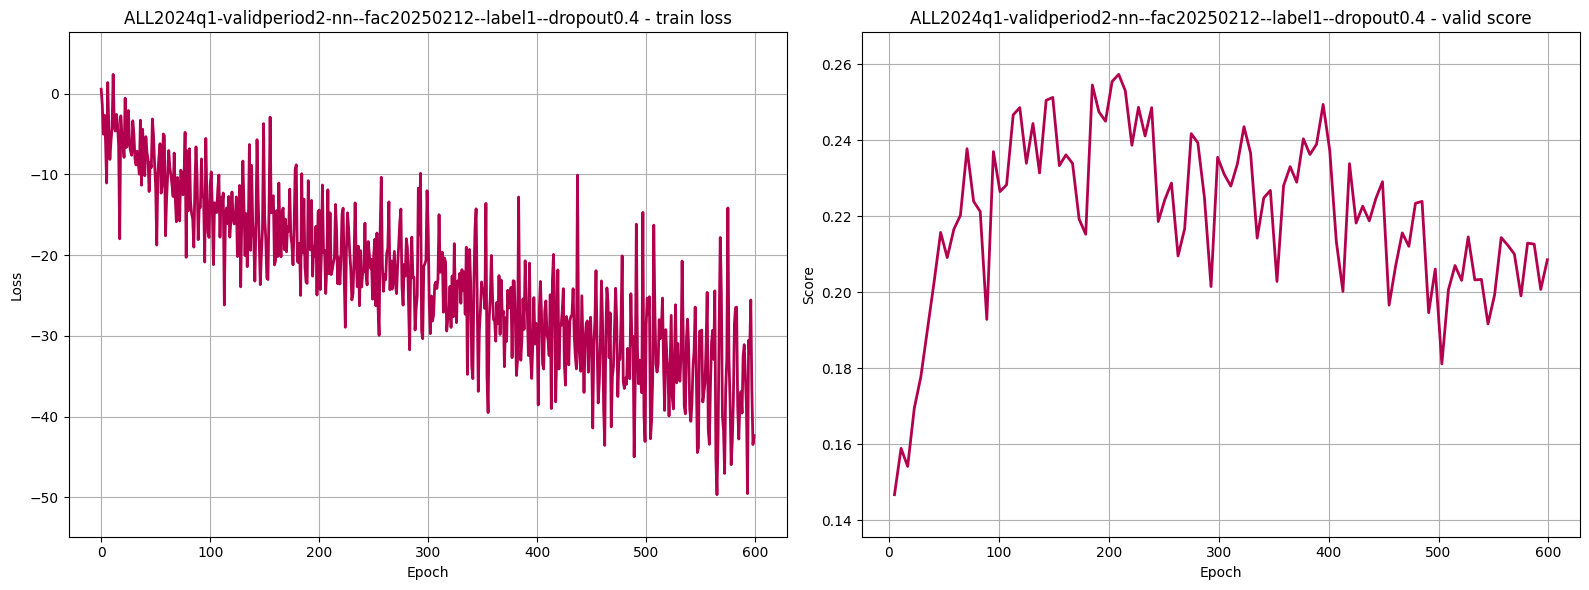

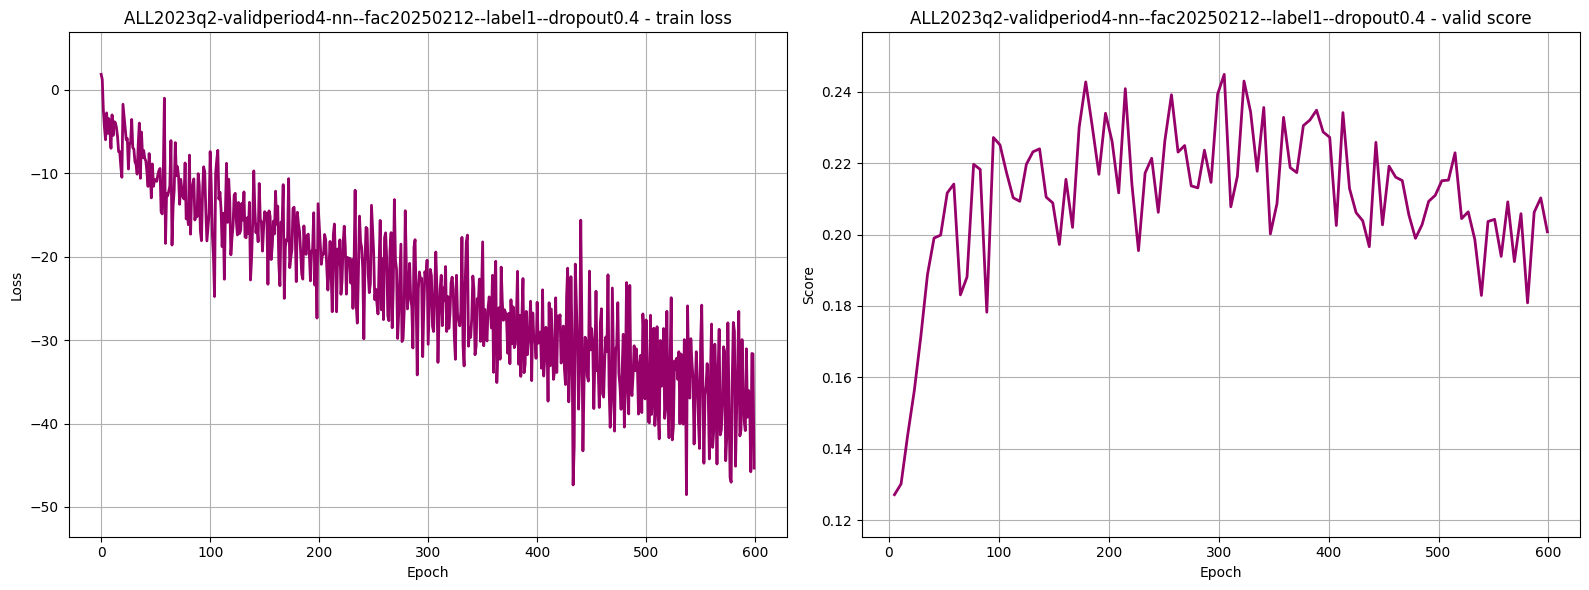

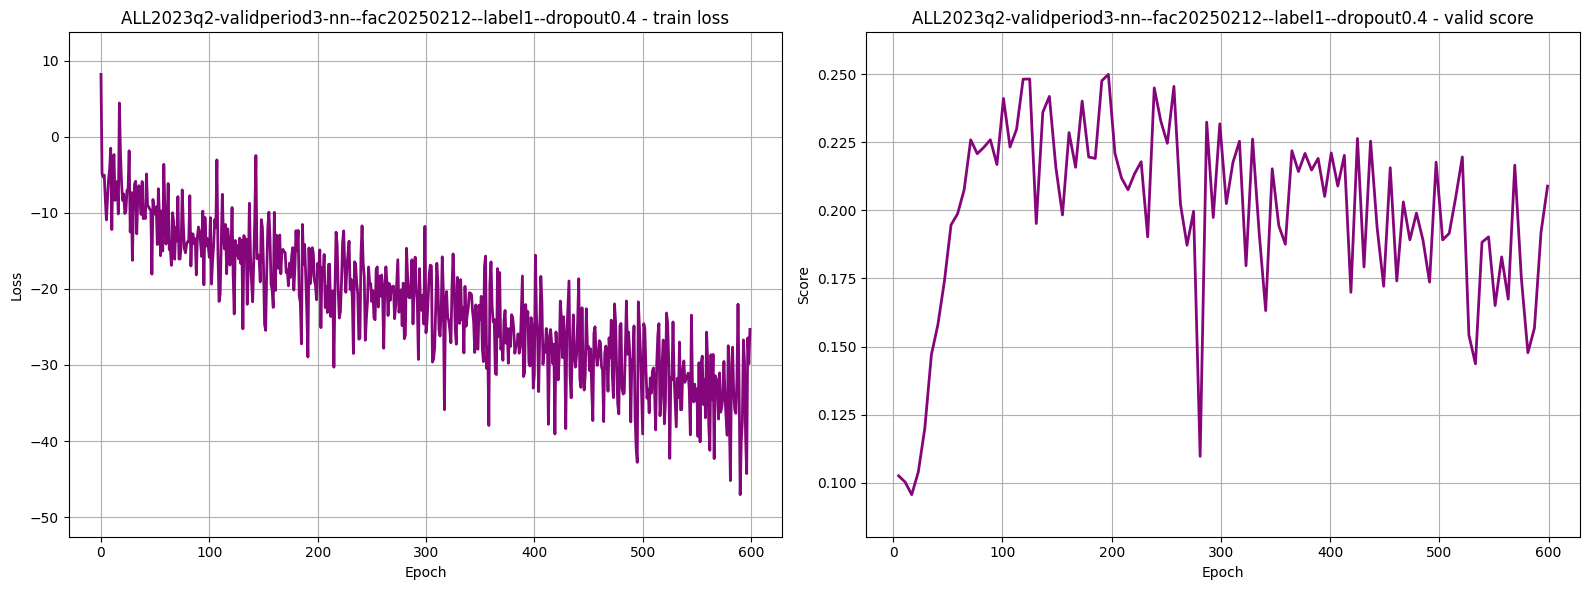

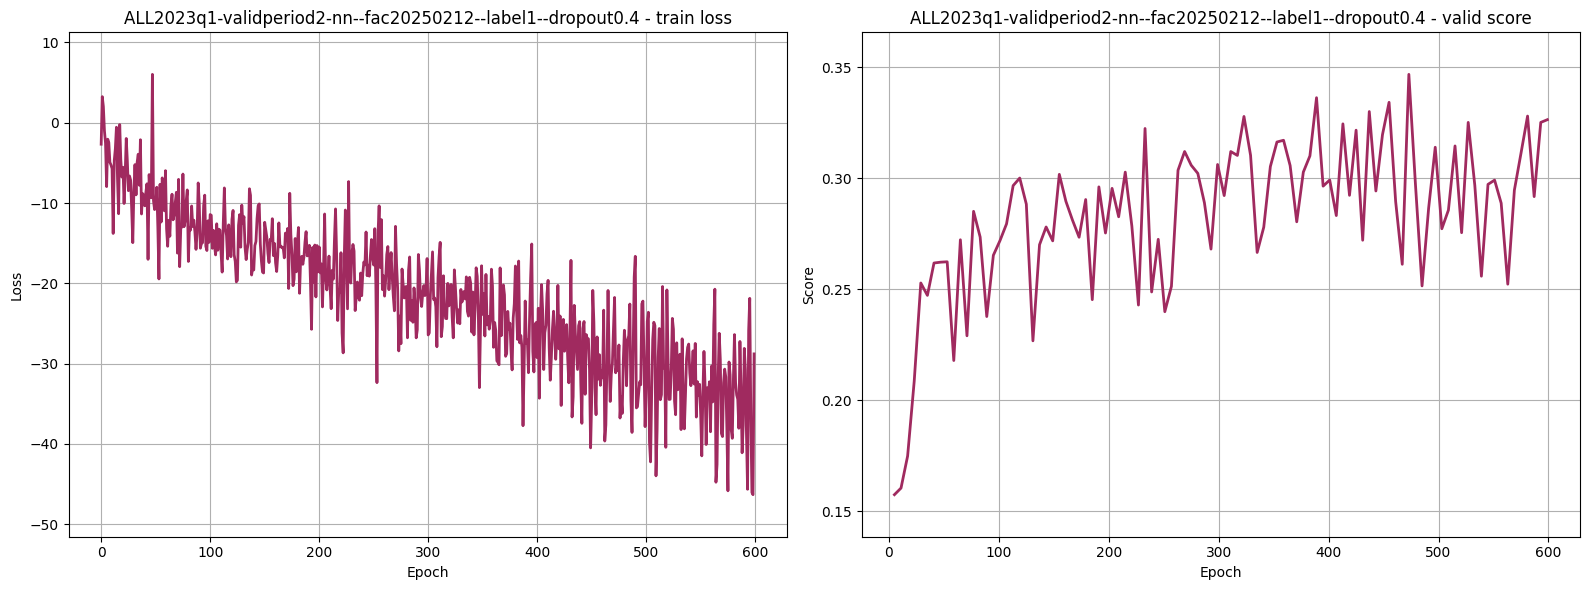

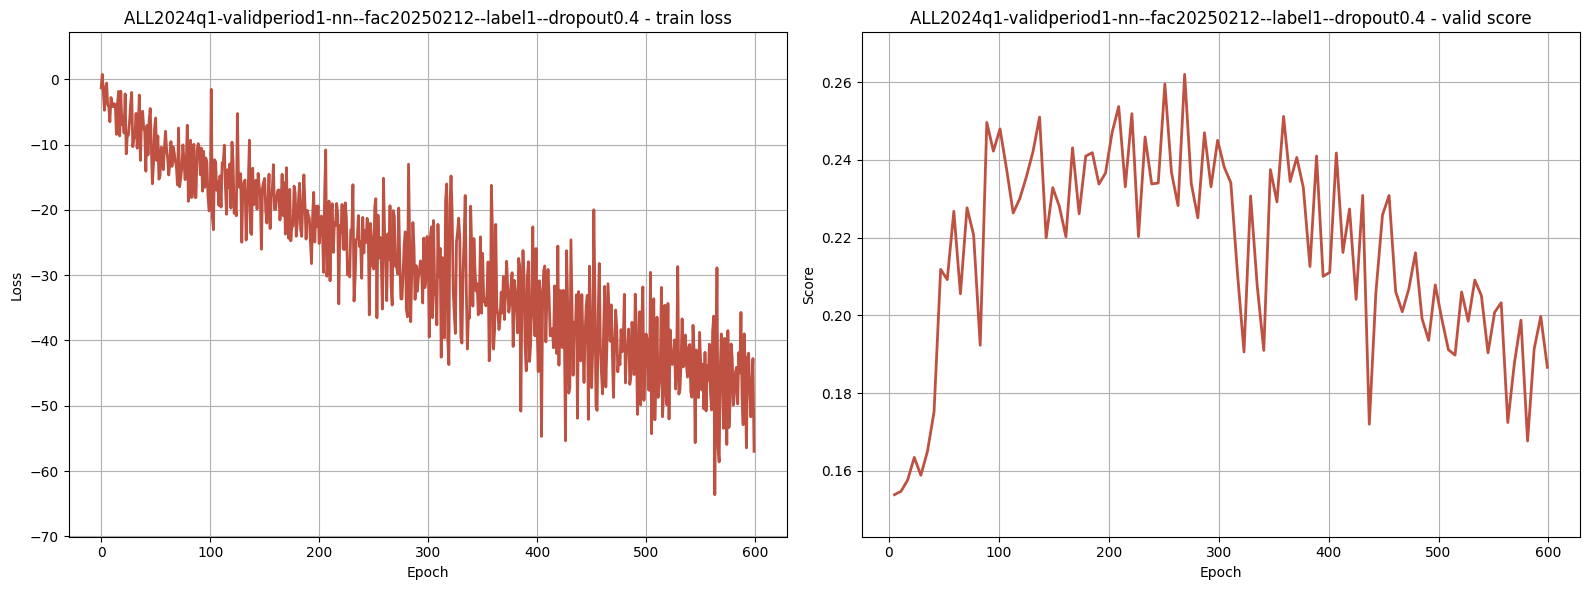

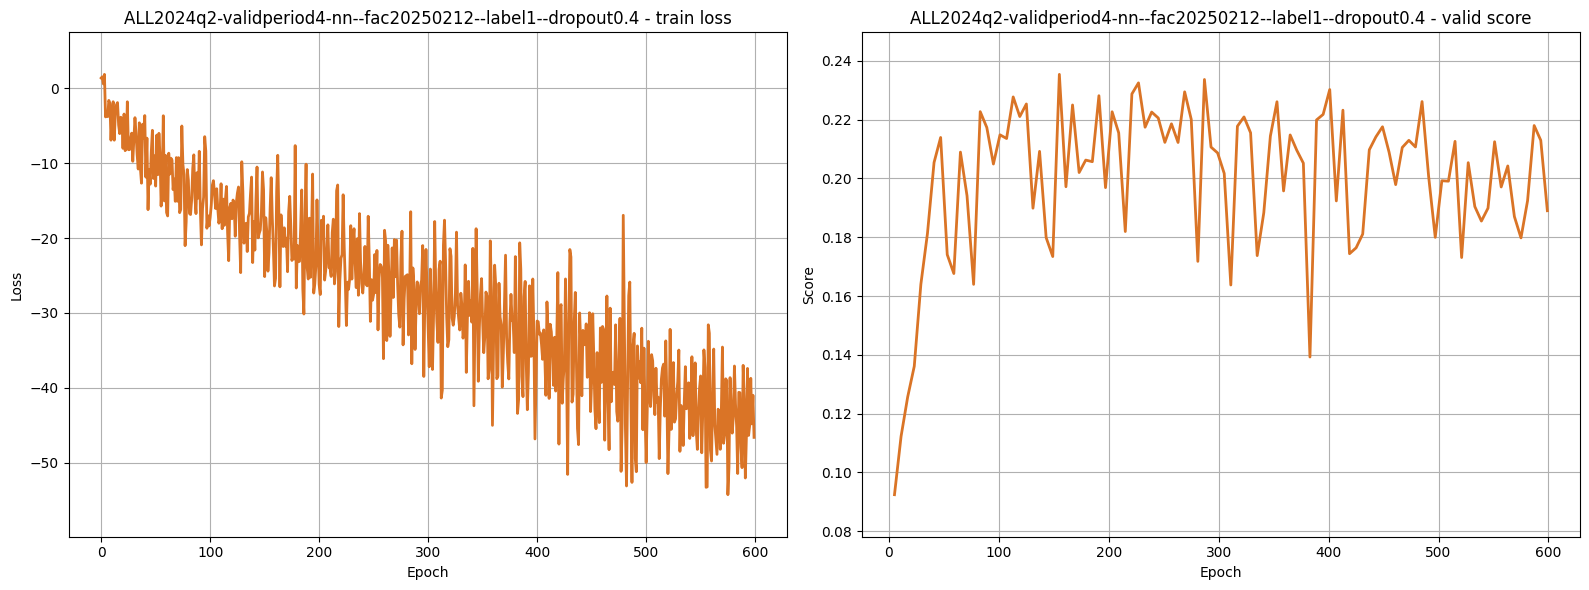

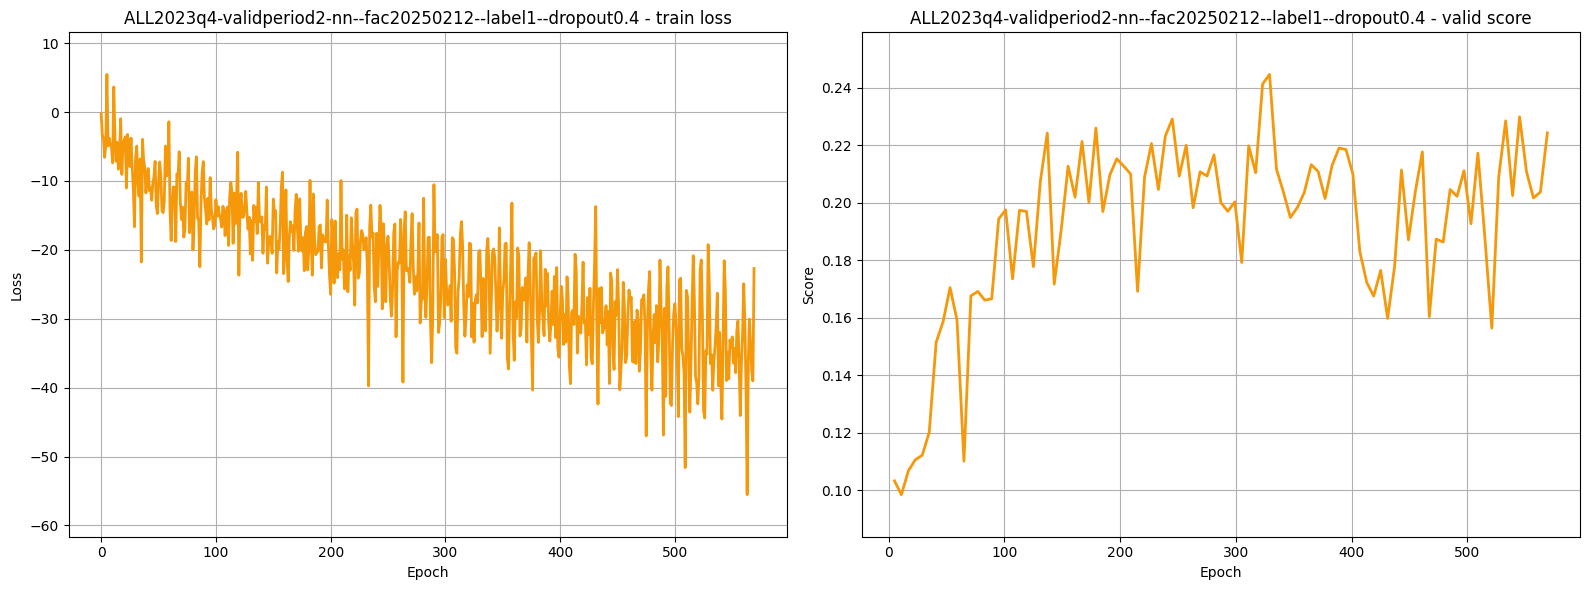

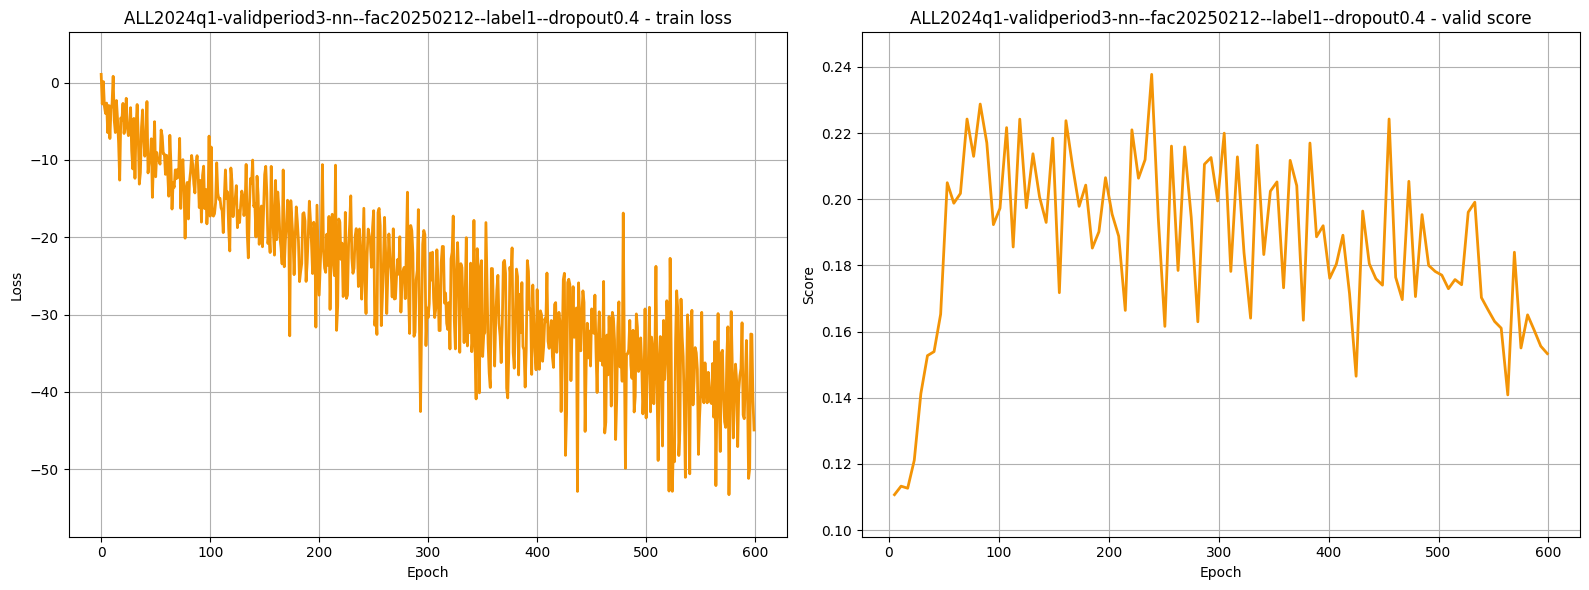

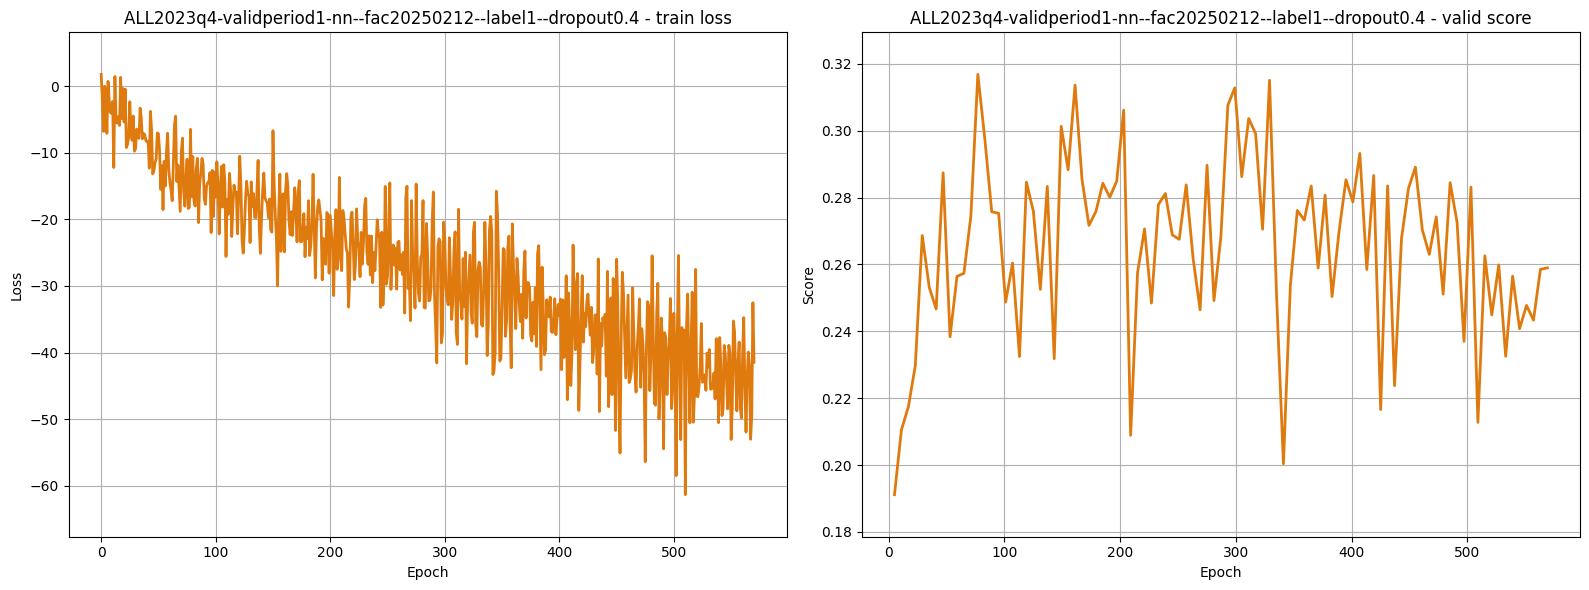

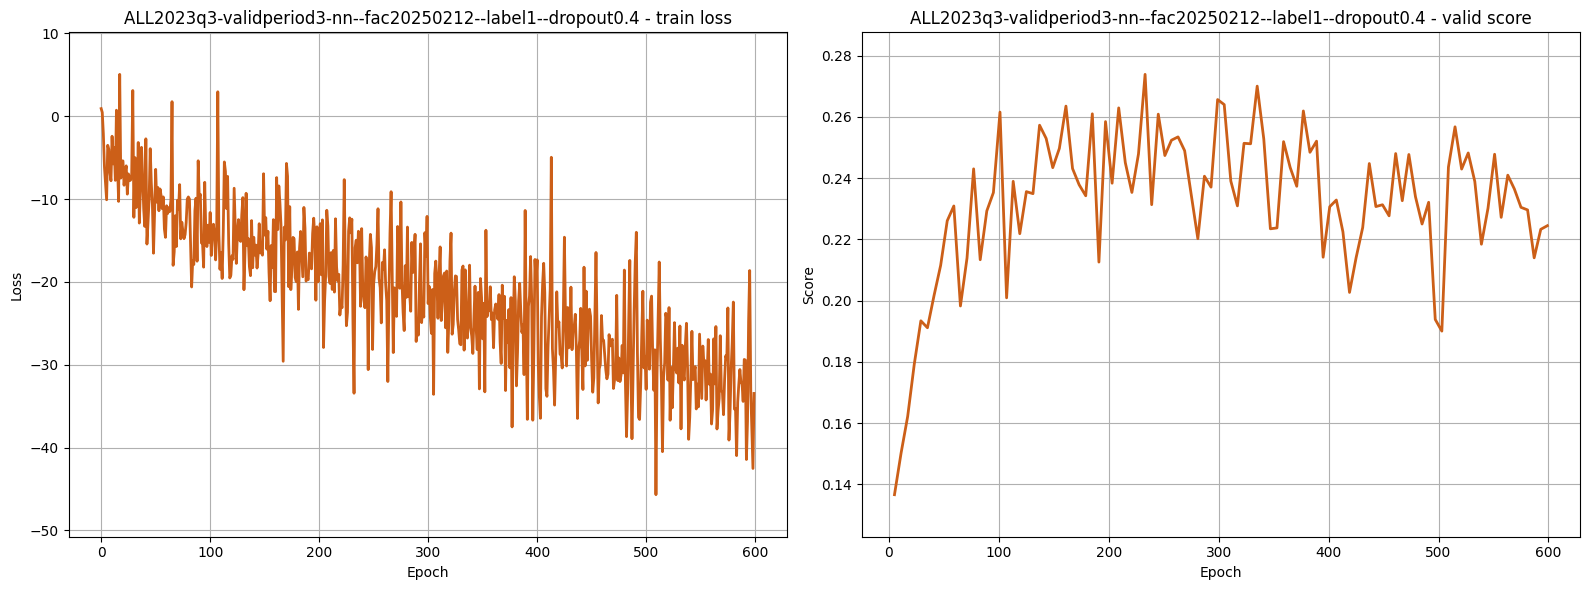

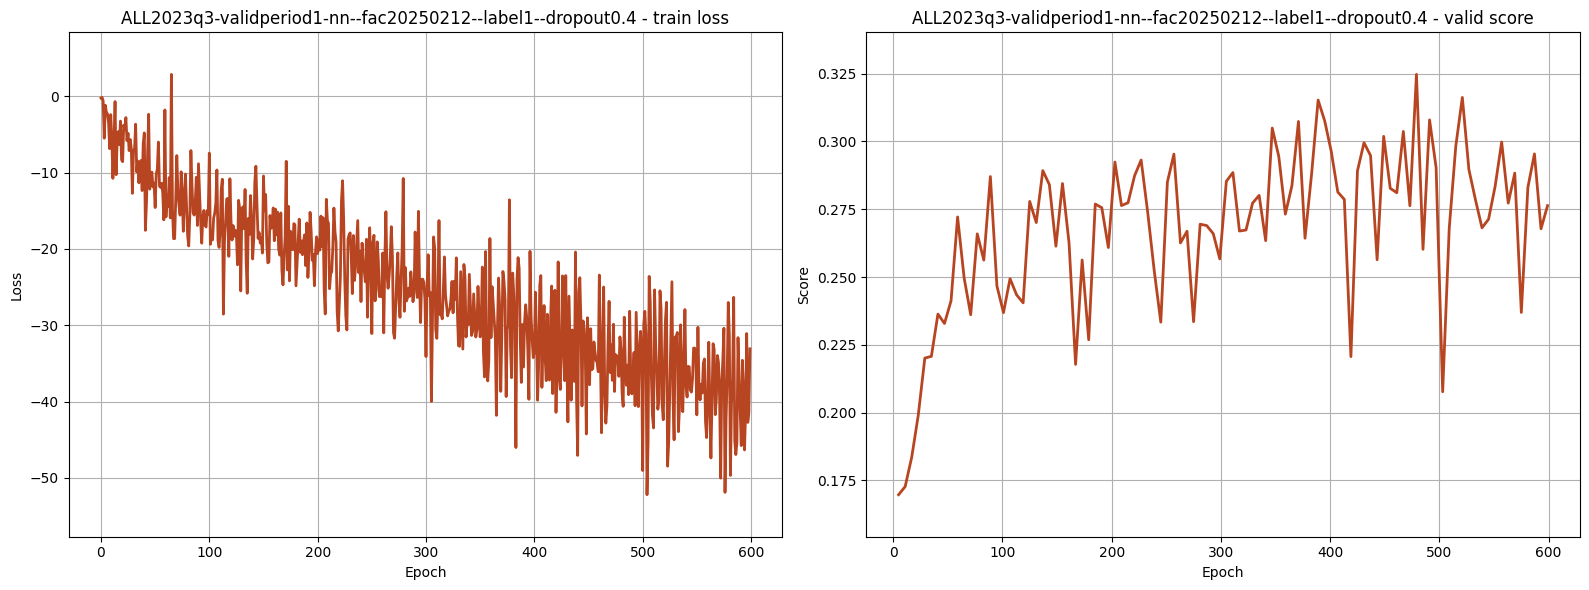

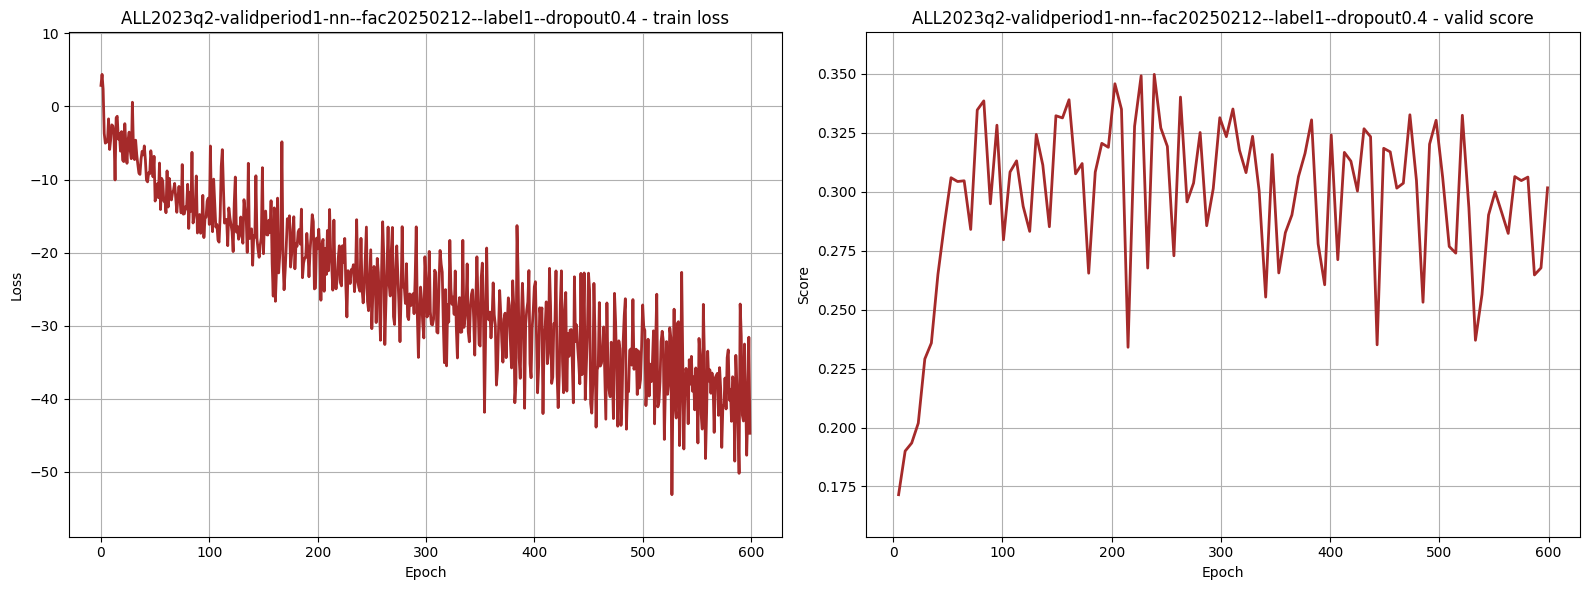

共绘制了 24 个模型的损失曲线


In [8]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# 确保matplotlib在Jupyter中正确显示
%matplotlib inline

def plot_single_loss_curves(root_path):
    """在Jupyter中为每个模型绘制单独的训练损失和验证指标曲线"""
    model_train_dir = os.path.join(root_path, "model_train")
    if not os.path.exists(model_train_dir):
        print(f"模型训练目录不存在: {model_train_dir}")
        return
    
    # 创建颜色映射
    cmap = LinearSegmentedColormap.from_list('my_cmap', ['blue', 'green', 'red', 'purple', 'orange', 'brown'])
    
    model_count = 0
    valid_models = []
    
    # 首先收集所有有效的模型文件夹
    for subfolder in os.listdir(model_train_dir):
        subfolder_path = os.path.join(model_train_dir, subfolder)
        if os.path.isdir(subfolder_path):
            log_dir = os.path.join(subfolder_path, "version_0")
            if os.path.exists(log_dir):
                try:
                    event_acc = EventAccumulator(log_dir)
                    event_acc.Reload()
                    
                    train_loss = event_acc.Scalars('train_loss')
                    val_wei = event_acc.Scalars('val_wei')
                    
                    if train_loss and val_wei:
                        valid_models.append(subfolder)
                except Exception as e:
                    print(f"处理 {subfolder} 时出错: {e}")
    
    # 为每个有效模型绘制单独的图表
    for i, subfolder in enumerate(valid_models):
        subfolder_path = os.path.join(model_train_dir, subfolder)
        log_dir = os.path.join(subfolder_path, "version_0")
        
        try:
            event_acc = EventAccumulator(log_dir)
            event_acc.Reload()
            
            train_loss = event_acc.Scalars('train_loss')
            val_wei = event_acc.Scalars('val_wei')
            
            df_train = pd.DataFrame([(x.step, x.value) for x in train_loss], columns=['epoch', 'train_loss'])
            df_val = pd.DataFrame([(x.step, x.value) for x in val_wei], columns=['epoch', 'val_wei'])
            
            # 确定y轴范围，增加一些边距
            train_min = df_train['train_loss'].min()
            train_max = df_train['train_loss'].max()
            val_min = df_val['val_wei'].min()
            val_max = df_val['val_wei'].max()
            
            train_margin = (train_max - train_min) * 0.1
            val_margin = (val_max - val_min) * 0.1
            
            # 创建图表
            plt.figure(figsize=(16, 6))
            color = cmap(i / max(1, len(valid_models) - 1))
            
            # 绘制训练损失
            plt.subplot(1, 2, 1)
            plt.title(f'{subfolder} - train loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.grid(True)
            plt.plot(df_train['epoch'], df_train['train_loss'], color=color, linewidth=2)
            plt.ylim(train_min - train_margin, train_max + train_margin)
            
            # 绘制验证指标
            plt.subplot(1, 2, 2)
            plt.title(f'{subfolder} - valid score')
            plt.xlabel('Epoch')
            plt.ylabel('Score')
            plt.grid(True)
            plt.plot(df_val['epoch'], df_val['val_wei'], color=color, linewidth=2)
            plt.ylim(val_min - val_margin, val_max + val_margin)
            
            plt.tight_layout()
            plt.show()
            
            model_count += 1
        except Exception as e:
            print(f"绘制 {subfolder} 图表时出错: {e}")
    
    print(f"共绘制了 {model_count} 个模型的损失曲线")

if __name__ == "__main__":
    root_path = root_path  # 项目根路径，根据需要修改
    plot_single_loss_curves(root_path)